# 카메라 스티커앱 만들기 첫걸음


In [1]:
# 필요한 라이브러리들을 불러옵니다.

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


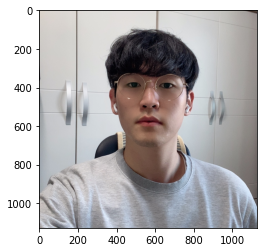

In [2]:
# OpenCV로 이미지를 불러와 저장하고 이미지를 출력해봅니다.
# OpenCV는 예외적으로 BGR이 아닌 RGB 방식이므로 이미지 컬러를 다르게 선언해줍니다.

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/My_face.png'
img_bgr = cv2.imread(my_image_path) 
img_show = img_bgr.copy() 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [3]:
# HOG를 통해 이미지 색상의 변화량을 나타내게 한다. 
# 그 이유는 이미지로부터 물체의 특징을 잘 잡아낼 수 있기 때문이다.
# 또 sliding window를 사용하게 되는데 이는 이미지 내 작은 영역을 이동해가며 얼굴을 확인하는 방법이다.
# detector_hog를 이용해 얼굴의 bounding box를 추출한다.

detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)
print("슝~")

슝~


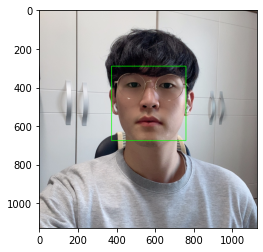

In [4]:
# dlib.rectangles 객체를 통해 찾은 얼굴 영역 박스의 좌표값을 저장하게된다.
# 또 찾은 얼굴 좌표값을 통해 화면에 나타내보았다.

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [5]:
# landmark 모델을 불러온다.
# landmark_predictor는 RGB 이미지랑 dlib.rectangle을 입력받게 되고 dlib.full_object_detection을 반환하게 된다.

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("슝~")

슝~


In [6]:
# 얼굴 영역 박스마다 face landmark를 찾아내게되고 그 좌표들을 list 안에 저장한다.

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


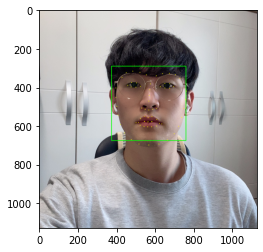

In [7]:
# lankmark를 통해 각 부위별 특징점을 출력하게 된다.

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255,255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [8]:
# 저장된 list 내에 있는 좌표점 중 30번째 index에 위치한 부위는 코부분이다.
# 이 코의 중심점 부위의 좌표점을 출력해준다. 

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(568, 471)
(x,y) : (568,278)
(w,h) : (386,386)


In [9]:
# 스티커 이미지를 불러와 위에서 계산한 w,h의 크기만큼 resize해준다.
# 또 x,y 좌표를 조정한다. 그 이유는 이미지 시작점이 top-left부터이기 때문이다.

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_sticker.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
x = x - w // 2
print('(x,y) : (%d,%d)'%(x, y))

(386, 386, 3)
(x,y) : (375,278)


In [10]:
# 이 작업은 얼굴 이미지에서 인식된 얼굴이 범위 근처 혹은 경계선에 겹쳐있을 확률이 있을텐데
# 그 상태에서 스티커를 넣을 경우 이미지 범위 밖으로 튀어 나오게 될 수 있다.
# 이를 방지하기 위해 x,y값이 음수일 경우 스티커가 잘려 나오게끔 해주는 작업인것이다.

if x < 0: 
    img_sticker = img_sticker[:, -x:]
    x = 0
if y < 0:
    img_sticker = img_sticker[-y:, :]
    y = 0
print ('(x,y) : (%d,%d)'%(x, y))

(x,y) : (375,278)


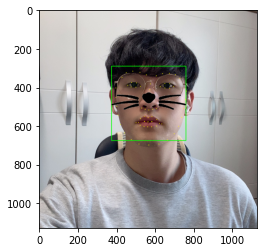

In [11]:
# 모든 작업이 끝나고  np.where를 통해 img_sticker가 255 즉, 횐색인 부분은
# sticker_area를 사용하고 255(흰색)가 아닌 부분을 img_sticker를 사용한다고 보면 된다.
# 그래서 스티커 이미지의 배경색인 흰색은 얼굴 이미지 부분이 나오게 되고,
# 스티커 이미지의 스티커 부분은 스티커 이미지가 정상적으로 나오게 되는 것이다.

sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 만약에 np.where 안의 값이 img_sticker==0이었다면
#### 어떻게 나오게될까?

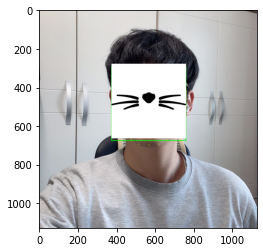

In [12]:
# 이렇게 우리가 원했던 바와는 정 반대로 나오게 될것이다.

sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### bounding box와 landmark를 제거하고 최종 출력을 해보자!

#### 아! 중요한 점을 빠트렸다.. 스티커를 투명하게 만드려면 어떻게 해야할까??

#### cv2.addWeighted()를 사용해보자고한다.

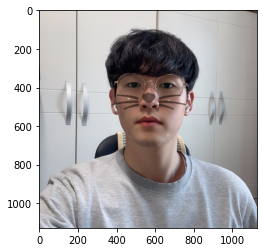

In [13]:
# add 인스턴스에 cv2.addWeighted를 통해 sticker_area에 0.5만큼 곱해주고, img_sticker에 0.3만큼 곱한 값을 주었다.
# 즉, 두 이미지를 addWeighted()를 통해 합치고 투명도를 준 것이다.
# 또 이 add를 12번째 줄 np.where에 img_sticker가 0인 경우 sticker_area 대신 아까 합친 결과물인 add를 나타내게 해준다.

sticker_area = img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]]

# img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
#     cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.5, -130)

add = cv2.addWeighted(sticker_area, 0.5, img_sticker, 0.3, 0)

img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,add,sticker_area).astype(np.uint8)

# img_bgr[y:y +img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
#     cv2.addWeighted(sticker_area, 1.0, img_sticker, 0.6, -150)

# plt.figure(figsize=(300,10))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

사실 이부분에서 굉장히 애를 먹었다..

어디에다가 추가해야할지, 어떻게 구현이 가능한지 정말로 답답했다. 결국엔 퍼실님과 함께 집단지성으로 성공했다...

그리고 얼굴이 비스듬한 경우에 스티커를 어떻게 구현하는지 얼굴 크기 별로 스티커를 어떻게 조절해야하는지 여러가지 응용방법이 많았지만 시간이 부족해서 여기까지만 하게되었다. 나중에 시간나면 조금 더 머리를 써봐야겠다.